In [14]:
import torch
import numpy as np

from typing import Optional, Callable
from adaptive_mcmc.linalg.logdet import *
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [2]:
n = 4
dtype = torch.float32
I = torch.eye(n, dtype=dtype)
#D = torch.eye(n) * 0.2 # torch.rand(n, n) * 0.2
D = torch.rand(n, n) * 0.2

def mv(v):
   return torch.einsum("...j,...j->...", D, v).unsqueeze(0)

def mv_lanczos(v):
   return torch.einsum("...j,...j->...", I + D, v).unsqueeze(0)

In [3]:
v = torch.ones(4, dtype=dtype)
v

tensor([1., 1., 1., 1.])

In [4]:
import torch


def lanczos_tridiag(
    matmul_closure,
    max_iter: int,
    matrix_shape: torch.Size,
    dtype: torch.dtype = torch.float32,
    device: torch.device = "cpu",
    batch_shape=torch.Size(),
    init_vecs: Optional[int] = None,
    num_init_vecs: int = 1,
    tol: float = 1e-5,
):
    """Lanczos tridiagonalization without any in-place operations."""
    # Initialize probing vectors
    if init_vecs is None:
        init_vecs = torch.randn(
            *batch_shape, matrix_shape[-1], num_init_vecs,
            dtype=dtype, device=device
        )
    else:
        if dtype != init_vecs.dtype or device != init_vecs.device:
            raise RuntimeError("init_vecs dtype or device mismatch.")
        if batch_shape != init_vecs.shape[:-2] or matrix_shape[-1] != init_vecs.size(-2):
            raise RuntimeError("batch_shape or matrix_shape mismatch init_vecs.")
        num_init_vecs = init_vecs.size(-1)

    # Max iterations
    num_iter = min(max_iter, matrix_shape[-1])
    dim_dim = -2

    # First Lanczos vector
    norm0 = torch.norm(init_vecs, p=2, dim=dim_dim, keepdim=True)
    q0 = init_vecs / norm0

    alpha_list: List[Tensor] = torch.jit.annotate(List[Tensor], [])
    beta_list: List[Tensor] = torch.jit.annotate(List[Tensor], [])
    q_list: List[Tensor] = torch.jit.annotate(List[Tensor], [])
    q_list.append(q0)
    
    # Compute initial alpha and beta
    r = matmul_closure(q0)
    alpha0 = (q0 * r).sum(dim_dim)
    alpha_list.append(alpha0)
    r = r - alpha0.unsqueeze(dim_dim) * q0
    beta0 = torch.norm(r, p=2, dim=dim_dim)
    beta_list.append(beta0)

    # First new Lanczos vector if possible
    if num_iter > 1:
        q1 = r / beta0.unsqueeze(dim_dim)
        q_list.append(q1)

    # Main Lanczos loop
    for k in range(1, num_iter):
        if k >= len(q_list):
            break
        q_prev = q_list[k - 1]
        q_curr = q_list[k]

        # Apply matrix and subtract previous beta term
        beta_prev = beta_list[k - 1].unsqueeze(dim_dim)
        r = matmul_closure(q_curr) - q_prev * beta_prev

        # Alpha
        alpha = (q_curr * r).sum(dim_dim)
        alpha_list.append(alpha)
        if k == num_iter - 1:
            break

        # Subtract current alpha component
        r = r - alpha.unsqueeze(dim_dim) * q_curr

        # Full reorthogonalization
        stacked_q = torch.stack(q_list, dim=0)
        corr = (r.unsqueeze(0) * stacked_q).sum(dim_dim, keepdim=True)
        corr = (stacked_q * corr).sum(0)
        r = r - corr

        # Normalize
        r_norm = torch.norm(r, p=2, dim=dim_dim, keepdim=True)
        r = r / r_norm

        # Beta
        beta = r_norm.squeeze(dim_dim)
        beta_list.append(beta)

        # Additional reorthogonalization if needed
        inner = (stacked_q * r.unsqueeze(0)).sum(dim_dim)
        for _ in range(10):
            if not torch.any(inner > tol):
                break
            corr = (r.unsqueeze(0) * stacked_q).sum(dim_dim, keepdim=True)
            corr = (stacked_q * corr).sum(0)
            r = r - corr
            r_norm = torch.norm(r, p=2, dim=dim_dim, keepdim=True)
            r = r / r_norm
            inner = (stacked_q * r.unsqueeze(0)).sum(dim_dim)

        q_list.append(r)

    # Number of Lanczos steps
    m = len(alpha_list)

    # Stack Q vectors: shape (m+1, *batch_shape, d, num_init_vecs)
    q_stack = torch.stack(q_list[: m + 1], dim=0)
    # Reorder to (num_init_vecs, *batch_shape, d, m+1)
    perm_q = [q_stack.dim() - 1] + list(range(1, 1 + len(batch_shape))) + [q_stack.dim() - 2, 0]
    q_out = q_stack.permute(*perm_q).contiguous()

    # Build tridiagonal T
    alpha_tensor = torch.stack(alpha_list, dim=0)
    if beta_list:
        beta_tensor = torch.stack(beta_list, dim=0)
    else:
        beta_tensor = torch.empty((0, *batch_shape, num_init_vecs), dtype=dtype, device=device)

    # Prepare for diag_embed: move iterations last
    # alpha_tensor: (m, *batch_shape, num_init_vecs) -> (*batch_shape, num_init_vecs, m)
    perm_a = list(range(1, 1 + len(batch_shape))) + [alpha_tensor.dim() - 1, 0]
    a_for_diag = alpha_tensor.permute(*perm_a)
    # beta_tensor: (m-1, *batch_shape, num_init_vecs) -> (*batch_shape, num_init_vecs, m-1)
    perm_b = list(range(1, 1 + len(batch_shape))) + [beta_tensor.dim() - 1, 0]
    b_for_diag = beta_tensor.permute(*perm_b)

    # Create diagonal matrices
    main_diag = torch.diag_embed(a_for_diag, offset=0)
    off_upper = torch.diag_embed(b_for_diag, offset=1)
    off_lower = torch.diag_embed(b_for_diag, offset=-1)

    T_full = main_diag + off_upper + off_lower  # shape: (*batch_shape, num_init_vecs, m, m)

    # Reorder T to (num_init_vecs, *batch_shape, m, m)
    perm_t = [len(batch_shape), *range(0, len(batch_shape)), len(batch_shape) + 1, len(batch_shape) + 2]
    t_out = T_full.permute(*perm_t).contiguous()

    # If single init vector, drop that dim
    if num_init_vecs == 1:
        q_out = q_out.squeeze(0)
        t_out = t_out.squeeze(0)

    return q_out, t_out


def lanczos_tridiag_to_diag(t_mat):
    """
    Given a num_init_vecs x num_batch x k x k tridiagonal matrix t_mat,
    returns a num_init_vecs x num_batch x k set of eigenvalues
    and a num_init_vecs x num_batch x k x k set of eigenvectors.

    TODO: make the eigenvalue computations done in batch mode.
    """
    orig_device = t_mat.device

    if t_mat.size(-1) < 32:
        retr = torch.linalg.eigh(t_mat.cpu())
    else:
        retr = torch.linalg.eigh(t_mat)

    evals, evecs = retr
    # mask = evals.ge(0)
    # evecs = evecs * mask.type_as(evecs).unsqueeze(-2)
    # evals = evals.masked_fill_(~mask, 1)

    return evals.to(orig_device), evecs.to(orig_device)
    

def lanczos_trace_estimator(matvec, dimension, batch_size,
                            probe_vector_count=10, lanczos_steps=10,
                            device='cpu', dtype=torch.float32, jitter=1e-6):
    """
    mv: (batch_size, n) -> (batch_size, n)
    """
    sum_trace = torch.zeros(batch_size, device=device, dtype=dtype)

    for _ in range(probe_vector_count):
        #z = torch.randint(0, 2, (batch_size, dimension), device=device, dtype=dtype) * 2 - 1

        _, t_mat = lanczos_tridiag(
            matmul_closure=matvec,
            max_iter=lanczos_steps,
            dtype=dtype,
            device=device,
            matrix_shape=torch.Size([dimension, dimension]),
            batch_shape=torch.Size([batch_size]),
            #init_vecs=z.unsqueeze(-1),
            num_init_vecs=1,
            tol=1e-5,
        )

        # z_norm = z.pow(2).sum(dim=-1)
        #t_mat = t_mat + torch.eye(t_mat.shape[-1]) * jitter
        try:
            evals, evecs = torch.linalg.eigh(t_mat)
        except torch._C._LinAlgError:
            print(t_mat)
            exit()

        # print("evecs", evecs.shape)
        weights = evecs[:, 0, ...].pow(2)
        # weights = evecs[..., 0].pow(2)
        log_evals = torch.log(torch.abs(evals))

        sum_trace = sum_trace + torch.sum(weights * log_evals, dim=-1) * dimension

    return sum_trace.div(probe_vector_count)

In [5]:
def lanczos_tridiag(
    matmul_closure: Callable,
    max_iter: int,
    matrix_shape: torch.Size,
    dtype: torch.dtype = torch.float32,
    device: torch.device = "cpu",
    batch_shape=torch.Size(),
    init_vecs: Optional[int] = None,
    num_init_vecs: int = 1,
    tol: float = 1e-5,
):
    """Lanczos tridiagonalization without any in-place operations.
    In the rest of the code matmul transforms (b, n, d) -> (b, n, d)
    or (b, d) -> (b, d). Here however transform is (b, d, n) -> (b, d, n)
    """

    moved = matmul_closure

    def matmul(v: Tensor) -> Tensor:
        # print(v.shape)
        return moved(v.transpose(-1, -2)).transpose(-1, -2)

    matmul_closure = matmul

    # Initialize probing vectors
    if init_vecs is None:
        init_vecs = torch.randn(
            *batch_shape, matrix_shape[-1], num_init_vecs,
            dtype=dtype, device=device
        )
        # init_vecs = torch.randint(0, 2, (*batch_shape, matrix_shape[-1], num_init_vecs,),
        #     dtype=dtype, device=device
        # ) - 1
    else:
        if dtype != init_vecs.dtype or device != init_vecs.device:
            raise RuntimeError("init_vecs dtype or device mismatch.")
        if batch_shape != init_vecs.shape[:-2] or matrix_shape[-1] != init_vecs.size(-2):
            raise RuntimeError("batch_shape or matrix_shape mismatch init_vecs.")
        num_init_vecs = init_vecs.size(-1)

    # Max iterations
    num_iter = min(max_iter, matrix_shape[-1])
    dim_dim = -2

    # First Lanczos vector
    norm0 = torch.norm(init_vecs, p=2, dim=dim_dim, keepdim=True)
    q0 = init_vecs / norm0

    alpha_list: List[Tensor] = torch.jit.annotate(List[Tensor], [])
    beta_list: List[Tensor] = torch.jit.annotate(List[Tensor], [])
    q_list: List[Tensor] = torch.jit.annotate(List[Tensor], [])
    q_list.append(q0)

    # Compute initial alpha and beta
    r = matmul_closure(q0)
    alpha0 = (q0 * r).sum(dim_dim)
    alpha_list.append(alpha0)
    r = r - alpha0.unsqueeze(dim_dim) * q0
    beta0 = torch.norm(r, p=2, dim=dim_dim)

    if torch.min(beta0) <= tol:
        # build T of size 1×1
        T = alpha0.unsqueeze(-1).unsqueeze(-1)  # shape (...,1,1)
        T = T.transpose(0, 1)
        q0 = q0.transpose(0, 1)
        return q0, T

    beta_list.append(beta0)

    # First new Lanczos vector if possible
    if num_iter > 1:
        q1 = r / beta0.unsqueeze(dim_dim)
        q_list.append(q1)

    # Main Lanczos loop
    for k in range(1, num_iter):
        if k >= len(q_list):
            break
        q_prev = q_list[k - 1]
        q_curr = q_list[k]

        # Apply matrix and subtract previous beta term
        beta_prev = beta_list[k - 1].unsqueeze(dim_dim)
        r = matmul_closure(q_curr) - q_prev * beta_prev

        # Alpha
        alpha = (q_curr * r).sum(dim_dim)
        alpha_list.append(alpha)
        if k == num_iter - 1:
            break

        # Subtract current alpha component
        r = r - alpha.unsqueeze(dim_dim) * q_curr

        # Full reorthogonalization
        stacked_q = torch.stack(q_list, dim=0)
        corr = (r.unsqueeze(0) * stacked_q).sum(dim_dim, keepdim=True)
        corr = (stacked_q * corr).sum(0)
        r = r - corr

        # Normalize
        r_norm = torch.norm(r, p=2, dim=dim_dim, keepdim=True)
        r = r / r_norm

        # Beta
        beta = r_norm.squeeze(dim_dim)

        if torch.min(beta) <= tol:
            break

        beta_list.append(beta)

        # Additional reorthogonalization if needed
        inner = (stacked_q * r.unsqueeze(0)).sum(dim_dim)
        for _ in range(10):
            if not torch.any(inner > tol):
                break
            corr = (r.unsqueeze(0) * stacked_q).sum(dim_dim, keepdim=True)
            corr = (stacked_q * corr).sum(0)
            r = r - corr
            r_norm = torch.norm(r, p=2, dim=dim_dim, keepdim=True)
            r = r / r_norm
            inner = (stacked_q * r.unsqueeze(0)).sum(dim_dim)

        q_list.append(r)

    # Number of Lanczos steps
    m = len(alpha_list)

    # Stack Q vectors: shape (m+1, *batch_shape, d, num_init_vecs)
    q_stack = torch.stack(q_list[: m + 1], dim=0)
    # Reorder to (num_init_vecs, *batch_shape, d, m+1)
    perm_q = [q_stack.dim() - 1] + list(range(1, 1 + len(batch_shape))) + [q_stack.dim() - 2, 0]
    q_out = q_stack.permute(*perm_q).contiguous()

    # Build tridiagonal T
    alpha_tensor = torch.stack(alpha_list, dim=0)
    if beta_list:
        beta_tensor = torch.stack(beta_list, dim=0)
    else:
        beta_tensor = torch.empty((0, *batch_shape, num_init_vecs), dtype=dtype, device=device)

    # Prepare for diag_embed: move iterations last
    # alpha_tensor: (m, *batch_shape, num_init_vecs) -> (*batch_shape, num_init_vecs, m)
    perm_a = list(range(1, 1 + len(batch_shape))) + [alpha_tensor.dim() - 1, 0]
    a_for_diag = alpha_tensor.permute(*perm_a)
    # beta_tensor: (m-1, *batch_shape, num_init_vecs) -> (*batch_shape, num_init_vecs, m-1)
    perm_b = list(range(1, 1 + len(batch_shape))) + [beta_tensor.dim() - 1, 0]
    b_for_diag = beta_tensor.permute(*perm_b)

    # Create diagonal matrices
    main_diag = torch.diag_embed(a_for_diag, offset=0)
    off_upper = torch.diag_embed(b_for_diag, offset=1)
    off_lower = torch.diag_embed(b_for_diag, offset=-1)

    T_full = main_diag + off_upper + off_lower  # shape: (*batch_shape, num_init_vecs, m, m)

    # Reorder T to (num_init_vecs, *batch_shape, m, m)
    perm_t = [len(batch_shape), *range(0, len(batch_shape)), len(batch_shape) + 1, len(batch_shape) + 2]
    t_out = T_full.permute(*perm_t).contiguous()

    # If single init vector, drop that dim
    if num_init_vecs == 1:
        q_out = q_out.squeeze(0)
        t_out = t_out.squeeze(0)

    return q_out, t_out


def lanczos_tridiag_to_diag(t_mat):
    """
    Given a num_init_vecs x num_batch x k x k tridiagonal matrix t_mat,
    returns a num_init_vecs x num_batch x k set of eigenvalues
    and a num_init_vecs x num_batch x k x k set of eigenvectors.

    TODO: make the eigenvalue computations done in batch mode.
    """
    orig_device = t_mat.device

    if t_mat.size(-1) < 32:
        retr = torch.linalg.eigh(t_mat.cpu())
    else:
        retr = torch.linalg.eigh(t_mat)

    evals, evecs = retr
    # mask = evals.ge(0)
    # evecs = evecs * mask.type_as(evecs).unsqueeze(-2)
    # evals = evals.masked_fill_(~mask, 1)

    return evals.to(orig_device), evecs.to(orig_device)


# def lanczos_trace_estimator(matvec, dimension, batch_size,
#                             probe_vector_count=10, lanczos_steps=10,
#                             device='cpu', dtype=torch.float32, jitter=1e-6):
#     """
#     mv: (batch_size, n) -> (batch_size, n)
#     """
#     sum_trace = torch.zeros(batch_size, device=device, dtype=dtype)
# 
#     for _ in range(probe_vector_count):
#         # z = torch.randint(0, 2, (batch_size, dimension), device=device, dtype=dtype) * 2 - 1
# 
#         q_mat, t_mat = lanczos_tridiag(
#             matmul_closure=matvec,
#             max_iter=lanczos_steps,
#             dtype=dtype,
#             device=device,
#             matrix_shape=torch.Size([dimension, dimension]),
#             batch_shape=torch.Size([batch_size]),
#             # init_vecs=z.unsqueeze(-1),
#             num_init_vecs=1,
#             tol=1e-5,
#         )
# 
#         # z_norm = z.pow(2).sum(dim=-1)
#         # t_mat = t_mat + torch.eye(t_mat.shape[-1]) * jitter
#         try:
#             evals, evecs = torch.linalg.eigh(t_mat)
#         except torch._C._LinAlgError:
#             print("naninf cnt", (~t_mat.isfinite()).sum())
#             exit()
# 
#         weights = evecs[:, 0, ...].pow(2)
#         log_evals = torch.log(torch.abs(evals))
# 
#         sum_trace = sum_trace + torch.sum(weights * log_evals, dim=-1) * dimension
# 
#     return sum_trace.div(probe_vector_count)


def lanczos_trace_estimator(matvec, dimension, batch_size,
                            probe_vector_count=10, lanczos_steps=10,
                            device='cpu', dtype=torch.float32, jitter=1e-6):
    q_mat, t_mat = lanczos_tridiag(
        matmul_closure=matvec,
        max_iter=lanczos_steps,
        dtype=dtype,
        device=device,
        matrix_shape=torch.Size([dimension, dimension]),
        batch_shape=torch.Size([batch_size]),
        num_init_vecs=probe_vector_count,
        tol=1e-5,
    )

    try:
        evals, evecs = torch.linalg.eigh(t_mat)
    except torch._C._LinAlgError:
        print("naninf cnt", (~t_mat.isfinite()).sum())
        raise torch._C._LinAlgError

    # evals: (n, b, k) or (b, k)
    # evecs: (n, b, k, k) or (b, k, k)

    weights = evecs[..., 0, :].pow(2)
    log_evals = torch.log(torch.abs(evals))

    return torch.sum(weights * log_evals, dim=-1).mean(dim=0) * dimension


In [19]:
import tqdm.notebook
import time


def random_symmetric(d, dtype=torch.float32, device="cpu"):
    A = torch.randn(d, d, dtype=dtype, device=device)
    return (A + A.T) / 2

def random_batch_symmetric(b, d):
    A = torch.randn(b, d, d)
    return (A + A.transpose(-2, -1)) * 0.5

n_tests = 100
b, d = 10, 32
lanczos_steps = 13

def t_reconst():
    for _ in range(n_tests):
        A = random_batch_symmetric(b, d)
        
        def matvec(v):
            # print("v", v.shape)
            # v: (b, k, d)
            # A: (b, d, d)
            # Av: (b, k, d)
            return torch.matmul(v, A)
        
        matrix_shape = torch.Size([d, d])
        batch_shape = torch.Size([b])
        
        q, t = lanczos_tridiag(
            matmul_closure=matvec,
            max_iter=lanczos_steps, 
            matrix_shape=matrix_shape,
            batch_shape=batch_shape,
        )
    
        assert torch.allclose(t, q.transpose(-1,-2) @ A @ q, atol=1e-6), "T reconst breaks"
    
    print("T reconst OK")


def eivals_test():
    for _ in range(n_tests):
        A = random_batch_symmetric(b, d)
        
        def matvec(v):
            # v: (b, d, k)
            # A: (b, d, d)
            # Av: (b, d, k)
            return torch.matmul(v, A)
        
        matrix_shape = torch.Size([d, d])
        batch_shape = torch.Size([b])
        
        _, t = lanczos_tridiag(
            matmul_closure=matvec,
            max_iter=d, 
            matrix_shape=matrix_shape,
            batch_shape=batch_shape,
        )
        
        evals_lanczos, _ = lanczos_tridiag_to_diag(t)
        evals_true = torch.linalg.eigvalsh(A)
        s_l, _ = torch.sort(evals_lanczos)
        s_t, _ = torch.sort(evals_true)
        
        assert torch.allclose(s_l, s_t, atol=1e-4), "Eigvals do not match!"
    
    print("Eigvals OK")

def gradtriag_test():
    for _ in range(n_tests):
        A = random_batch_symmetric(b, d)
        A = A.requires_grad_()
        
        def matvec(v):
            # v: (b, d, k)
            # A: (b, d, d)
            # Av: (b, d, k)
            return torch.matmul(v, A)
        
        matrix_shape = torch.Size([d, d])
        batch_shape = torch.Size([b])
        
        q, t = lanczos_tridiag(
            matmul_closure=matvec,
            max_iter=d, 
            matrix_shape=matrix_shape,
            batch_shape=batch_shape,
        )
        
        evals, evecs = lanczos_tridiag_to_diag(t)
        
        loss = evals.sum() + evecs.sum()
        loss.backward()
    
    print("Gradtriag OK")


def logdet_test(b, d, lanczos_steps=10, probe_vector_count=10, rtol=5e-2, n_tests=25):
    for _ in tqdm.trange(n_tests):
        A = random_batch_symmetric(b, d)
        
        def matvec(v):
            # v: (b, d, k)
            # A: (b, d, d)
            # Av: (b, d, k)
            return torch.matmul(v, A)

        det_est = lanczos_trace_estimator(
            matvec=matvec,
            dimension=d,
            batch_size=b,
            probe_vector_count=probe_vector_count,
            lanczos_steps=lanczos_steps,
            device=A.device,
            dtype=A.dtype,
            jitter=1e-6
        )
        _, det_true = torch.linalg.slogdet(A)
        
        # print(det_est, det_true)

        assert torch.allclose(det_est, det_true, rtol=rtol, atol=0.), "det isn't accurate"

    print("det OK")


def logdet_test_dev(b, d, lanczos_steps=10, probe_vector_count=10, rtol=5e-2, n_tests=25):
    ret = 0
    t_est, t_true = 0, 0
    for _ in tqdm.notebook.trange(n_tests):
        A = random_batch_symmetric(b, d)
        
        def matvec(v):
            # v: (b, d, k)
            # A: (b, d, d)
            # Av: (b, d, k)
            return torch.matmul(v, A)

        t0 = time.perf_counter()
        det_est = lanczos_trace_estimator(
            matvec=matvec,
            dimension=d,
            batch_size=b,
            probe_vector_count=probe_vector_count,
            lanczos_steps=lanczos_steps,
            device=A.device,
            dtype=A.dtype,
            jitter=1e-6
        )
        t_est += time.perf_counter() - t0

        t0 = time.perf_counter()
        _, det_true = torch.linalg.slogdet(A)
        t_true += time.perf_counter() - t0

        ret += ((det_est - det_true) / det_true).abs().mean()

    return ret / n_tests, t_est / n_tests, t_true / n_tests


def graddet_test(lanczos_steps=10, probe_vector_count=10):    
    for _ in tqdm.trange(n_tests):
        A = random_batch_symmetric(b, d)
        A = A.requires_grad_()
        
        def matvec(v):
            # v: (b, d, k)
            # A: (b, d, d)
            # Av: (b, d, k)
            return torch.matmul(v, A)

        det_est = lanczos_trace_estimator(
            matvec=matvec,
            dimension=d,
            batch_size=b,
            probe_vector_count=probe_vector_count,
            lanczos_steps=lanczos_steps,
            device=A.device,
            dtype=A.dtype,
            jitter=1e-6
        )
        det_est.sum().backward()

    print("Graddet OK")


def logdet_time_test(b, d, lanczos_steps=10, probe_vector_count=10, rtol=5e-2, n_tests=25):
    t_est, t_true = 0, 0
    for _ in tqdm.notebook.trange(n_tests):
        A = random_batch_symmetric(b, d)
        
        def matvec(v):
            # v: (b, d, k)
            # A: (b, d, d)
            # Av: (b, d, k)
            return torch.matmul(v, A)
            
        t0 = time.perf_counter()
        det_est = lanczos_trace_estimator(
            matvec=matvec,
            dimension=d,
            batch_size=b,
            probe_vector_count=probe_vector_count,
            lanczos_steps=lanczos_steps,
            device=A.device,
            dtype=A.dtype,
            jitter=1e-6
        )
        t_est += time.perf_counter() - t0

        t0 = time.perf_counter()
        _, det_true = torch.linalg.slogdet(A)
        t_true += time.perf_counter() - t0

    print("t_est:", t_est / n_tests)
    print("t_true:", t_true / n_tests)

In [7]:
t_reconst()
eivals_test()
gradtriag_test()
graddet_test()
#logdet_test(b=10, d=32, lanczos_steps=3, probe_vector_count=10)

T reconst OK
Eigvals OK
Gradtriag OK


100%|██████████| 100/100 [00:00<00:00, 269.81it/s]

Graddet OK


In [ ]:
logdet_test(b=50, d=1024, lanczos_steps=4, probe_vector_count=1, rtol=2e-1)

In [17]:
logdet_test_dev(b=50, d=8, lanczos_steps=8, probe_vector_count=10)

  0%|          | 0/25 [00:00<?, ?it/s]

tensor(2.1770)

In [ ]:
logdet_test_dev(b=50, d=16, lanczos_steps=8, probe_vector_count=10)

In [ ]:
logdet_test_dev(b=50, d=64, lanczos_steps=8, probe_vector_count=1)

In [ ]:
logdet_test_dev(b=50, d=1024, lanczos_steps=8, probe_vector_count=1)

In [20]:
dev = []
t_est = []
t_true = []


dims = [int(2**i) for i in range(4, 12)]
for dim in tqdm.notebook.tqdm(dims):
    dev_, t_est_, t_true_ = logdet_test_dev(b=50, d=dim, lanczos_steps=8, probe_vector_count=1)

    dev.append(dev_)
    t_est.append(t_est_)
    t_true.append(t_true_)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

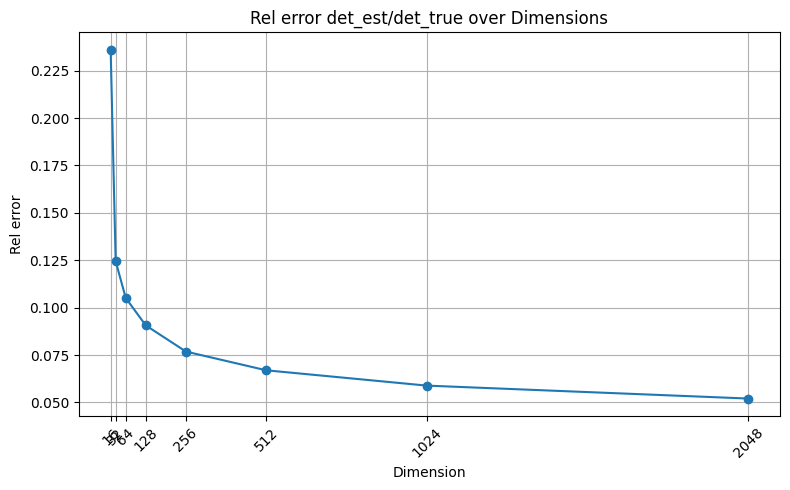

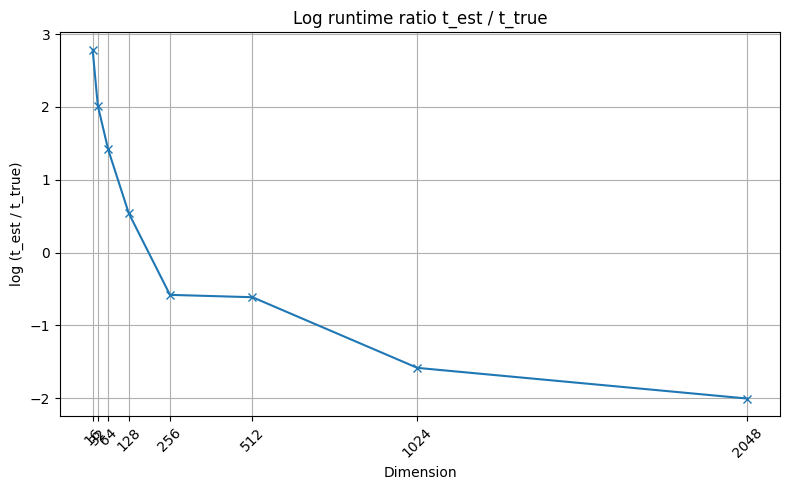

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# assuming you’ve already populated these lists:
# dev, t_est, t_true, dims
# e.g. dims = [2**i for i in range(4, 12)]

# compute relative difference
t_est = np.array(t_est)
t_true = np.array(t_true)
relative_diff = np.log(np.abs(t_est / t_true))

# plot deviation over dimensions
plt.figure(figsize=(8, 5))
plt.plot(dims, dev, marker='o', linestyle='-')
plt.xlabel('Dimension')
plt.ylabel('Rel error')
plt.title('Rel error det_est/det_true over Dimensions')
plt.grid(True)
plt.xticks(dims, dims, rotation=45)
plt.tight_layout()
plt.show()

# plot relative difference over dimensions
plt.figure(figsize=(8, 5))
plt.plot(dims, relative_diff, marker='x', linestyle='-')
plt.xlabel('Dimension')
plt.ylabel('log (t_est / t_true)')
plt.title('Log runtime ratio t_est / t_true')
plt.grid(True)
plt.xticks(dims, dims, rotation=45)
plt.tight_layout()
plt.show()


Text(0, 0.5, 'rel error')

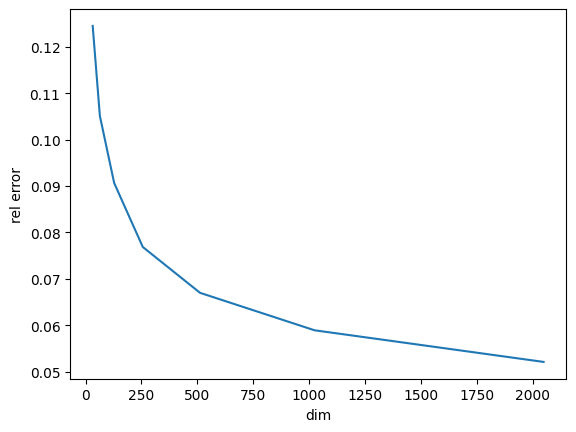

In [21]:
plt.plot(dims[1:], dev[1:])
plt.xlabel("dim")
plt.ylabel("rel error")

In [24]:
logdet_time_test(b=50, d=1024, lanczos_steps=8, probe_vector_count=1, n_tests=100, rtol=1e-5)

  0%|          | 0/100 [00:00<?, ?it/s]

t_est: 0.04195159086259082
t_true: 0.22376332860905676


In [ ]:
logdet_test(b=10, d=1024, lanczos_steps=10, probe_vector_count=10, rtol=5e-2, n_tests=10)

In [ ]:
import time
import torch
from linear_operator.operators import DenseLinearOperator
from linear_operator.settings import (
    max_lanczos_quadrature_iterations,
    num_trace_samples,
)

# Build an SPD matrix A
n = 15000
G = torch.randn(n, n)
A = G @ G.t() + 1e-3 * torch.eye(n)
A = A.requires_grad_()

# Wrap in the DenseLinearOperator
lazy_A = DenseLinearOperator(A)

# SLQ parameters
lanczos_steps      = 4
probe_vector_count = 4

# Time SLQ log‑det via stochastic Lanczos quadrature
if A.device.type == "cuda":
    torch.cuda.synchronize()
t0 = time.perf_counter()
with max_lanczos_quadrature_iterations(lanczos_steps), \
     num_trace_samples(probe_vector_count):
    logdet_slq = lazy_A.logdet()
if A.device.type == "cuda":
    torch.cuda.synchronize()
t_slq = time.perf_counter() - t0

# Time exact log‑det
if A.device.type == "cuda":
    torch.cuda.synchronize()
t1 = time.perf_counter()
logdet_true = torch.logdet(A)
if A.device.type == "cuda":
    torch.cuda.synchronize()
t_exact = time.perf_counter() - t1

print(f"SLQ estimate = {logdet_slq.item():.6f}, time = {t_slq:.3f}s")
print(f"Exact logdet  = {logdet_true.item():.6f}, time = {t_exact:.3f}s")
print(f"Absolute error= {abs(logdet_slq - logdet_true).item():.2e}")


In [ ]:
import torch
import torch.nn.functional as F

# Original function under test
def tridiag_matmul(
    x: torch.Tensor,
    lower: torch.Tensor = None,
    diag:  torch.Tensor = None,
    upper: torch.Tensor = None,
) -> torch.Tensor:
    """
    Multiply a batch of tridiagonal matrices by x, without forming the full matrix.
    lower: (b, d‑1)  – sub‑diagonal entries
    diag:  (b, d)    – main‑diagonal entries
    upper: (b, d‑1)  – super‑diagonal entries
    x:     (b, d) or (b, d, n)
    returns y = T @ x with shape (b, d) or (b, d, n)
    """
    print(x.shape)
    y = torch.zeros_like(x)
    if diag is not None:
        if x.dim() == 3:
            diag = diag.unsqueeze(-1)
        y = y + diag * x

    if upper is not None:
        if x.dim() == 3:
            upper = upper.unsqueeze(-1)
        up_contrib = upper * x[..., 1:]               # (..., d-1)
        y = y + F.pad(up_contrib, (0, 1))             # (..., d)

    if lower is not None:
        if x.dim() == 3:
            lower = lower.unsqueeze(-1)
        lo_contrib = lower * x[..., :-1]              # (..., d-1)
        y = y + F.pad(lo_contrib, (1, 0))             # (..., d)

    return y

# Helper to build the full tridiagonal and multiply
def full_tridiag_matmul(lower, diag, upper, x):
    b, d = diag.shape
    T = torch.zeros(b, d, d, dtype=diag.dtype, device=diag.device)
    idx = torch.arange(d, device=diag.device)
    if diag is not None:
        T[:, idx, idx] = diag
    if upper is not None:
        T[:, idx[:-1], idx[1:]] = upper
    if lower is not None:
        T[:, idx[1:], idx[:-1]] = lower
    if x.dim() == 2:       # (b, d)
        return torch.bmm(T, x.unsqueeze(-1)).squeeze(-1)
    else:                  # (b, d, n)
        return torch.bmm(T, x)

def run_tests():
    torch.manual_seed(0)
    # Test forward for various shapes and band combinations
    for batch in (1, 3):
        for d in (2, 5):
            for n in (1, 4):
                diag  = torch.randn(batch, d, requires_grad=True)
                lower = torch.randn(batch, d-1, requires_grad=True)
                upper = torch.randn(batch, d-1, requires_grad=True)
                x_vec = torch.randn(batch, d, requires_grad=True)
                x_mat = torch.randn(batch, d, n, requires_grad=True)

                for use_lower, use_diag, use_upper in [
                    (False, True, False),
                    (True,  True, False),
                    (False, True, True),
                    (True,  True, True),
                ]:
                    l = lower  if use_lower else None
                    m = diag   if use_diag  else None
                    u = upper  if use_upper else None

                    # vector case
                    y1 = tridiag_matmul(x_vec, l, m, u)
                    y2 = full_tridiag_matmul(l, m, u, x_vec)
                    assert torch.allclose(y1, y2, atol=1e-6), \
                        f"Forward vec mismatch b={batch},d={d},bands={(use_lower,use_diag,use_upper)}"

    print("Forward tests passed")

    # Test gradients
    batch, d, n = 2, 5, 3
    diag  = torch.randn(batch, d, requires_grad=True)
    lower = torch.randn(batch, d-1, requires_grad=True)
    upper = torch.randn(batch, d-1, requires_grad=True)
    x_vec = torch.randn(batch, d, requires_grad=True)

    y = tridiag_matmul(x_vec, lower, diag, upper)
    loss = y.pow(2).sum()
    loss.backward()
    grads_test = {
        'diag':  diag.grad.clone(),
        'lower': lower.grad.clone(),
        'upper': upper.grad.clone(),
        'x_vec': x_vec.grad.clone(),
    }

    # Compare against full matrix gradient
    diag2, lower2, upper2, x2 = [
        t.clone().detach().requires_grad_(True)
        for t in (diag, lower, upper, x_vec)
    ]
    y_full = full_tridiag_matmul(lower2, diag2, upper2, x2)
    loss2  = y_full.pow(2).sum()
    loss2.backward()
    grads_ref = {
        'diag':  diag2.grad,
        'lower': lower2.grad,
        'upper': upper2.grad,
        'x_vec': x2.grad,
    }

    for k in grads_test:
        assert torch.allclose(grads_test[k], grads_ref[k], atol=1e-6), f"Grad mismatch for {k}"
    print("Gradient tests passed")

if __name__ == "__main__":
    run_tests()


In [ ]:
x = torch.rand(10).requires_grad_()

y = (x**2).sum()

In [ ]:
y.backward()

In [ ]:
x.grad